In [1]:
import logging
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA

from randnn import ContinuousNN, get_attractor_dimension, scaling_analysis, downsample, downsample_split, avg_over
from randnn.utils import np_cache, eigsort
from randnn.plotting import *
from randnn.transfer_operator import *


In [2]:
rc('text', usetex=True)
logging.basicConfig(level=logging.INFO)

COUPLING_STRENGTH = 10
N_NEURONS = 1000

In [20]:
cont_nn = ContinuousNN(coupling_strength=COUPLING_STRENGTH, n_dofs=N_NEURONS, max_step=0.1)
trajectory = cont_nn.run(n_steps=1000, n_burn_in=200)
lyapunov_spectrum = cont_nn.get_lyapunov_spectrum(trajectory, t_ons=100)
print("Attractor dimension: {}".format(get_attractor_dimension(lyapunov_spectrum)))

INFO:root:Loading from save ./saves/trajectories/trajectory-51dc62de4bc0125a18cdd8fc9ffc1190.npy
INFO:root:Loading from save ./saves/lyapunov/spectrum-d54f8061d2c30924230185d3ac8f53ca.npy


Attractor dimension: 95.17880159354898


/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle((0, 0),


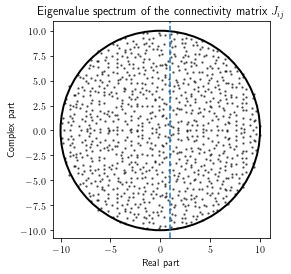

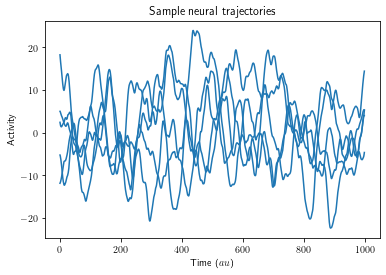

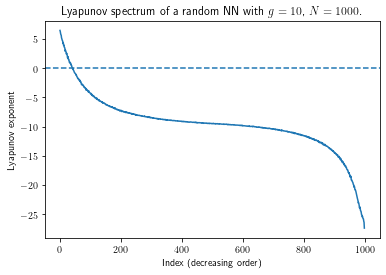

In [21]:
## Plot the eigenvalue spectrum and make sure it respects Girko's circular law
plot_random_matrix_spectrum(cont_nn.coupling_matrix, COUPLING_STRENGTH)
plt.show()
plot_trajectory_samples(trajectory, 5)
plt.show()
plot_lyapunov_spectrum(lyapunov_spectrum, title="Lyapunov spectrum of a random NN with $g={}$, $N={}$.".format(COUPLING_STRENGTH, N_NEURONS))
plt.show()

Generating samples: 100%|██████████| 10000/10000 [00:03<00:00, 3084.75it/s]
INFO:root:Saving to ./saves/trajectories/trajectory-7694ca679a164c62d8889a500c8b9ae6.npy
Burning-in Osedelets matrix: 0it [00:00, ?it/s]
QR-Decomposition of trajectory: 10000it [00:51, 195.79it/s]
INFO:root:Saving to ./saves/lyapunov/spectrum-6b7b634b3af54ce13f3d15be19b85d36.npy


(1000, 48)


/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/transfer_operator.py:243: RuntimeWarning: divide by zero encountered in true_divide
  return (sp.diags(1.0 / invariant_dist) * trans_matrix.T *
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1267: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Absolute value.')

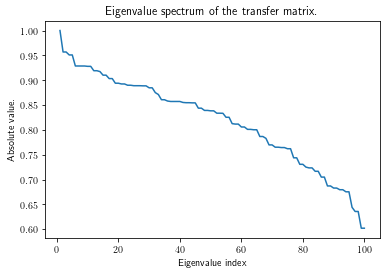

In [19]:
@downsample(10)
#@downsample_split(10)
def get_pca_reduced_trajectory(coupling_strength=10, n_dofs=500, n_steps=10000, n_burn_in=200, t_ons=100):
    cont_nn = ContinuousNN(coupling_strength=coupling_strength, n_dofs=n_dofs, max_step=0.1)
    trajectory = cont_nn.run(n_steps=n_steps, n_burn_in=n_burn_in)
    lyapunov_spectrum = cont_nn.get_lyapunov_spectrum(trajectory, t_ons=t_ons)
    effective_dim = int(np.ceil(get_attractor_dimension(lyapunov_spectrum)))
    pca = PCA(effective_dim)
    return pca.fit_transform(trajectory)

response = get_pca_reduced_trajectory()
print(response.shape)

transfer_operator = TransferOperator(labeling_method="kmeans", n_delays=0, embedding_dim=33)

#@avg_over("time_series")
def get_trans_matrix(time_series=None, n_clusters=100, n_future_timesteps=1):
    return transfer_operator.get_trans_matrix(time_series=time_series, n_clusters=n_clusters, n_future_timesteps=n_future_timesteps)

trans_matrix = get_trans_matrix(time_series=response)
invariant_dist = transfer_operator.get_invariant_dist(trans_matrix)
rev_trans_matrix = transfer_operator.get_reversible_trans_matrix(trans_matrix, invariant_dist)
spectrum, eig_vecs = eigsort(trans_matrix.T, 100, which='LR')
plt.plot(np.arange(1,101), spectrum) 
plt.title("Eigenvalue spectrum of the transfer matrix.")
plt.xlabel("Eigenvalue index")
plt.ylabel("Absolute value.")


In [10]:
print(dimensions)
fig = plt.figure()
plt.title("Attractor dimension, $D$, with network size, $N$")
plt.ylabel("Attractor dimension, $D$")
plt.xlabel("Network size, $N$")
plt.plot(dimensions[:,0], dimensions[:,1], "-x")

NameError: name 'dimensions' is not defined